In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [4]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
        
    filtered_cv_results[['C', 'epsilon', 'fit_time', 'n_iter', 
                         'train_r2', 'val_r2']] = cv_results[['param_C', 'param_epsilon', 'mean_fit_time', 'mean_train_n_iter', 
                                                              'mean_train_r2', 'mean_test_r2']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)
    
    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

In [5]:
from sklearn.datasets import make_regression
from optiml.ml.utils import generate_nonlinearly_regression_data

lin_X, lin_y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)
nonlin_X, nonlin_y = generate_nonlinearly_regression_data()

## Epsilon-insensitive loss

### Primal formulation

In [6]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [83]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.epoch + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

In [ ]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_ins_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-20, x_max=80, y_min=-40, y_max=60)
eps_ins_loss_opt = plot_trajectory_optimization(eps_ins_loss, grid.best_estimator_.optimizer, 
                                                color='k', label='none')

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [ ]:
none_primal_svr_eps_ins_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svr_eps_ins_cv_results.insert(0, 'solver', 'sgd')
none_primal_svr_eps_ins_cv_results.insert(2, 'momentum', 'none')
none_primal_svr_eps_ins_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
none_primal_svr_eps_ins_cv_results

In [ ]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='standard', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_ins_loss_opt = plot_trajectory_optimization(eps_ins_loss_opt, grid.best_estimator_.optimizer, 
                                                color='b', label='standard')
eps_ins_loss_opt

In [ ]:
standard_primal_svr_eps_ins_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svr_eps_ins_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svr_eps_ins_cv_results.insert(2, 'momentum', 'standard')
standard_primal_svr_eps_ins_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
standard_primal_svr_eps_ins_cv_results

In [ ]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='nesterov', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_ins_loss_opt = plot_trajectory_optimization(eps_ins_loss_opt, grid.best_estimator_.optimizer, 
                                                color='r', label='nesterov')
eps_ins_loss_opt.savefig('./tex/img/svr_eps_loss.png')
eps_ins_loss_opt

In [ ]:
nesterov_primal_svr_eps_ins_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svr_eps_ins_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svr_eps_ins_cv_results.insert(2, 'momentum', 'nesterov')
nesterov_primal_svr_eps_ins_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
nesterov_primal_svr_eps_ins_cv_results

In [ ]:
custom_primal_svr_eps_cv_results = none_primal_svr_eps_ins_cv_results.append(standard_primal_svr_eps_ins_cv_results).append(nesterov_primal_svr_eps_ins_cv_results)
custom_primal_svr_eps_cv_results.sort_values(['C', 'momentum'], key=lambda x: x.astype(str).str.len(), inplace=True)
custom_primal_svr_eps_cv_results

In [ ]:
grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive', random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

In [ ]:
liblinear_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
liblinear_primal_svr_eps_cv_results

In [ ]:
primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(liblinear_primal_svr_eps_cv_results)
primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_svr_eps.tex', 
                                   caption='SVR Primal formulation results with Epsilon-insensitive loss', 
                                   label='primal_svr_eps_cv_results', position='H')
primal_svr_eps_cv_results

### Dual formulations

In [18]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [19]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT

class SklSVR(SVR):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [20]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SklSVR) else (svr.iter if isinstance(svr.optimizer, str) 
                                                                   else svr.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svr.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 18 candidates, totalling 54 fits
     pcost       dcost       gap    pres   dres
 0: -9.4975e+03 -2.8399e+05  3e+05  3e-13  3e-15
 1: -4.7740e+04 -9.4352e+04  5e+04  9e-13  4e-15
 2: -7.0202e+04 -7.7261e+04  7e+03  9e-13  4e-15
 3: -7.4090e+04 -7.5044e+04  1e+03  7e-13  5e-15
 4: -7.4443e+04 -7.4808e+04  4e+02  2e-12  4e-15
 5: -7.4563e+04 -7.4715e+04  2e+02  1e-12  3e-15
 6: -7.4644e+04 -7.4647e+04  3e+00  7e-13  4e-15
 7: -7.4645e+04 -7.4645e+04  3e-02  1e-12  4e-15
Optimal solution found.


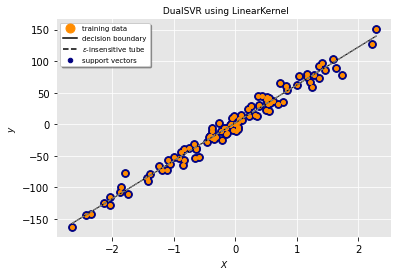

In [21]:
grid = GridSearchCV(DualSVR(kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_svr_hyperplane.png')

In [22]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
cvxopt 1   0.1      0.017656       9  0.917772  0.914479          67        67
           0.2      0.017439       9  0.918341  0.915058          67        67
           0.3      0.013357      10  0.918942  0.915614          66        66
       10  0.1      0.024514       9  0.977920  0.972466          67        67
           0.2      0.018264       9  0.977926  0.972474          67        67
           0.3      0.025372      10  0.977954  0.972562          66        66
       100 0.1      0.020310       9  0.977788  0.974150          67        67
           0.2      0.024708       9  0.977742  0.974033          67        67
           0.3      0.021550       9  0.977737  0.973956          67        67
smo    1   0.1      0.017338      15  0.917773  0.914442          66        66
           0.2      0.022597      13  0.918341  0.915019          66        66
           0.3      0.039421      60  0.918942  0.915576          66        66
       10  0.1      0.053832      56  0.977920  0.972445          66        66
           0.2      0.139534     219  0.977926  0.972457          65        65
           0.3      0.053870      38  0.977953  0.972544          65        65
       100 0.1      0.524643    1508  0.977788  0.974139          66        66
           0.2      0.266404     394  0.977742  0.974022          66        66
           0.3      0.383196     900  0.977737  0.973939          66        66

In [23]:
grid = GridSearchCV(SklSVR(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LibSVM]

In [24]:
libsvm_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
libsvm_linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
libsvm 1   0.1      0.003532      63  0.917627  0.915448          66        66
           0.2      0.003926     102  0.918194  0.915985          66        66
           0.3      0.002088      54  0.918786  0.916554          66        66
       10  0.1      0.001896     282  0.977852  0.972051          66        66
           0.2      0.001990     193  0.977851  0.972025          65        65
           0.3      0.001814     593  0.977870  0.972135          65        65
       100 0.1      0.003821    2621  0.977723  0.974270          66        66
           0.2      0.003551    2709  0.977673  0.974122          66        66
           0.3      0.003090    4141  0.977655  0.974045          66        66

In [50]:
linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(libsvm_linear_dual_svr_cv_results)
linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], ascending=[False, True, True], inplace=True)
linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_svr.tex', 
                                    caption='Linear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                    label='linear_dual_svr_cv_results', position='H')
linear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
solver C   epsilon                                                            
smo    1   0.1      0.017338      15  0.917773  0.914442          66        66
           0.2      0.022597      13  0.918341  0.915019          66        66
           0.3      0.039421      60  0.918942  0.915576          66        66
       10  0.1      0.053832      56  0.977920  0.972445          66        66
           0.2      0.139534     219  0.977926  0.972457          65        65
           0.3      0.053870      38  0.977953  0.972544          65        65
       100 0.1      0.524643    1508  0.977788  0.974139          66        66
           0.2      0.266404     394  0.977742  0.974022          66        66
           0.3      0.383196     900  0.977737  0.973939          66        66
libsvm 1   0.1      0.003532      63  0.917627  0.915448          66        66
           0.2      0.003926     102  0.918194  0.915985          66        66
           0.3      0.002088      54  0.918786  0.916554          66        66
       10  0.1      0.001896     282  0.977852  0.972051          66        66
           0.2      0.001990     193  0.977851  0.972025          65        65
           0.3      0.001814     593  0.977870  0.972135          65        65
       100 0.1      0.003821    2621  0.977723  0.974270          66        66
           0.2      0.003551    2709  0.977673  0.974122          66        66
           0.3      0.003090    4141  0.977655  0.974045          66        66
cvxopt 1   0.1      0.017656       9  0.917772  0.914479          67        67
           0.2      0.017439       9  0.918341  0.915058          67        67
           0.3      0.013357      10  0.918942  0.915614          66        66
       10  0.1      0.024514       9  0.977920  0.972466          67        67
           0.2      0.018264       9  0.977926  0.972474          67        67
           0.3      0.025372      10  0.977954  0.972562          66        66
       100 0.1      0.020310       9  0.977788  0.974150          67        67
           0.2      0.024708       9  0.977742  0.974033          67        67
           0.3      0.021550       9  0.977737  0.973956          67        67

##### Nonlinear

Fitting 3 folds for each of 18 candidates, totalling 54 fits
     pcost       dcost       gap    pres   dres
 0:  9.9715e+02 -2.2300e+04  2e+04  1e-12  3e-10
 1:  8.5320e+02 -1.8712e+03  3e+03  8e-13  4e-10
 2:  1.0993e+02 -2.8737e+02  4e+02  7e-13  3e-10
 3: -9.7931e+01 -1.8053e+02  8e+01  1e-13  2e-10
 4: -1.2403e+02 -1.6190e+02  4e+01  3e-13  1e-10
 5: -1.3775e+02 -1.5326e+02  2e+01  1e-12  1e-10
 6: -1.4364e+02 -1.4872e+02  5e+00  4e-13  1e-10
 7: -1.4600e+02 -1.4675e+02  8e-01  8e-14  1e-10
 8: -1.4633e+02 -1.4647e+02  1e-01  2e-13  1e-10
 9: -1.4640e+02 -1.4641e+02  6e-03  2e-13  1e-10
10: -1.4640e+02 -1.4640e+02  6e-05  4e-13  2e-10
Optimal solution found.


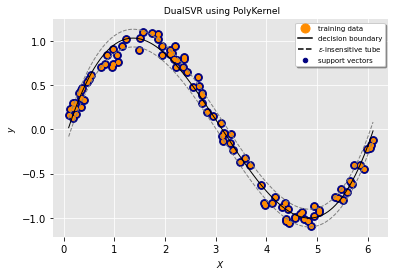

In [42]:
grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_svr_hyperplane.png')

In [43]:
poly_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results

fit_time   n_iter  train_r2     val_r2  \
solver kernel C   epsilon                                              
cvxopt poly   1   0.1         0.017180       10  0.116876 -16.797868   
                  0.2         0.017883       10 -4.948070 -13.077320   
                  0.3         0.012003       10  0.681960 -44.133994   
              10  0.1         0.011285       10  0.953326 -10.961264   
                  0.2         0.012770       10 -3.642113 -12.971183   
                  0.3         0.012743       10  0.783199 -43.962270   
              100 0.1         0.011621       10  0.951861  -9.443374   
                  0.2         0.013602       10 -3.642117 -12.971070   
                  0.3         0.013014       10  0.783091 -43.966539   
smo    poly   1   0.1        26.889628    38855  0.041472 -20.235896   
                  0.2         2.366264     3607 -5.523525 -24.564063   
                  0.3         1.063623     1440  0.121370 -48.392546   
              10  0.1       368.357509   939877  0.357291 -11.310659   
                  0.2         2.833490     4317 -4.173750 -24.504696   
                  0.3         0.861725     1396  0.227988 -48.232256   
              100 0.1      2431.854217  7053217  0.334627 -12.438814   
                  0.2         2.970568     4317 -4.173750 -24.504696   
                  0.3         0.860159     1396  0.227988 -48.232256   

                           train_n_sv  val_n_sv  
solver kernel C   epsilon                        
cvxopt poly   1   0.1              20        20  
                  0.2               5         5  
                  0.3               4         4  
              10  0.1              22        22  
                  0.2               4         4  
                  0.3               3         3  
              100 0.1              44        44  
                  0.2               4         4  
                  0.3               3         3  
smo    poly   1   0.1              20        20  
                  0.2               5         5  
                  0.3               4         4  
              10  0.1              19        19  
                  0.2               4         4  
                  0.3               3         3  
              100 0.1              20        20  
                  0.2               4         4  
                  0.3               3         3

Fitting 3 folds for each of 18 candidates, totalling 54 fits


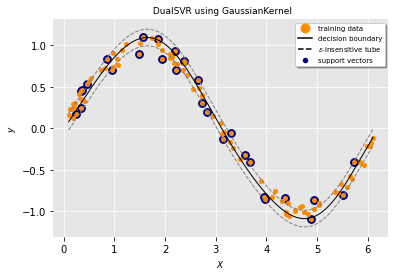

In [44]:
grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_svr_hyperplane.png')

In [45]:
rbf_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver kernel C   epsilon                                                     
cvxopt rbf    1   0.1      0.016085      10  0.981573 -0.007460          20   
                  0.2      0.019686       9  0.958544 -1.311340           7   
                  0.3      0.015890      10  0.932149 -2.681785           5   
              10  0.1      0.015052      10  0.981853  0.676330          20   
                  0.2      0.022038      10  0.950457 -1.330465           6   
                  0.3      0.016398      10  0.925512 -2.695479           5   
              100 0.1      0.021050      10  0.979321  0.229817          20   
                  0.2      0.016424      10  0.950458 -1.330472           6   
                  0.3      0.015113      10  0.924244 -2.228071           5   
smo    rbf    1   0.1      0.070852      53  0.982232 -0.107260          20   
                  0.2      0.015128      14  0.959560 -1.732727           6   
                  0.3      0.011491      12  0.935447 -2.495198           5   
              10  0.1      0.527717     398  0.981400  0.739074          18   
                  0.2      0.015757      16  0.951327 -1.750890           5   
                  0.3      0.010530      12  0.929203 -2.514675           4   
              100 0.1      1.742027    2574  0.979866  0.087491          17   
                  0.2      0.013848      16  0.951327 -1.750890           5   
                  0.3      0.008658      12  0.929203 -2.514675           4   

                           val_n_sv  
solver kernel C   epsilon            
cvxopt rbf    1   0.1            20  
                  0.2             7  
                  0.3             5  
              10  0.1            20  
                  0.2             6  
                  0.3             5  
              100 0.1            20  
                  0.2             6  
                  0.3             5  
smo    rbf    1   0.1            20  
                  0.2             6  
                  0.3             5  
              10  0.1            18  
                  0.2             5  
                  0.3             4  
              100 0.1            17  
                  0.2             5  
                  0.3             4

In [46]:
custom_nonlinear_dual_svr_cv_results = poly_nonlinear_dual_svr_cv_results.append(rbf_nonlinear_dual_svr_cv_results)
custom_nonlinear_dual_svr_cv_results.sort_values(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
custom_nonlinear_dual_svr_cv_results

fit_time   n_iter  train_r2     val_r2  \
solver kernel C   epsilon                                              
cvxopt poly   1   0.1         0.017180       10  0.116876 -16.797868   
                  0.2         0.017883       10 -4.948070 -13.077320   
                  0.3         0.012003       10  0.681960 -44.133994   
              10  0.1         0.011285       10  0.953326 -10.961264   
                  0.2         0.012770       10 -3.642113 -12.971183   
                  0.3         0.012743       10  0.783199 -43.962270   
              100 0.1         0.011621       10  0.951861  -9.443374   
                  0.2         0.013602       10 -3.642117 -12.971070   
                  0.3         0.013014       10  0.783091 -43.966539   
       rbf    1   0.1         0.016085       10  0.981573  -0.007460   
                  0.2         0.019686        9  0.958544  -1.311340   
                  0.3         0.015890       10  0.932149  -2.681785   
              10  0.1         0.015052       10  0.981853   0.676330   
                  0.2         0.022038       10  0.950457  -1.330465   
                  0.3         0.016398       10  0.925512  -2.695479   
              100 0.1         0.021050       10  0.979321   0.229817   
                  0.2         0.016424       10  0.950458  -1.330472   
                  0.3         0.015113       10  0.924244  -2.228071   
smo    poly   1   0.1        26.889628    38855  0.041472 -20.235896   
                  0.2         2.366264     3607 -5.523525 -24.564063   
                  0.3         1.063623     1440  0.121370 -48.392546   
              10  0.1       368.357509   939877  0.357291 -11.310659   
                  0.2         2.833490     4317 -4.173750 -24.504696   
                  0.3         0.861725     1396  0.227988 -48.232256   
              100 0.1      2431.854217  7053217  0.334627 -12.438814   
                  0.2         2.970568     4317 -4.173750 -24.504696   
                  0.3         0.860159     1396  0.227988 -48.232256   
       rbf    1   0.1         0.070852       53  0.982232  -0.107260   
                  0.2         0.015128       14  0.959560  -1.732727   
                  0.3         0.011491       12  0.935447  -2.495198   
              10  0.1         0.527717      398  0.981400   0.739074   
                  0.2         0.015757       16  0.951327  -1.750890   
                  0.3         0.010530       12  0.929203  -2.514675   
              100 0.1         1.742027     2574  0.979866   0.087491   
                  0.2         0.013848       16  0.951327  -1.750890   
                  0.3         0.008658       12  0.929203  -2.514675   

                           train_n_sv  val_n_sv  
solver kernel C   epsilon                        
cvxopt poly   1   0.1              20        20  
                  0.2               5         5  
                  0.3               4         4  
              10  0.1              22        22  
                  0.2               4         4  
                  0.3               3         3  
              100 0.1              44        44  
                  0.2               4         4  
                  0.3               3         3  
       rbf    1   0.1              20        20  
                  0.2               7         7  
                  0.3               5         5  
              10  0.1              20        20  
                  0.2               6         6  
                  0.3               5         5  
              100 0.1              20        20  
                  0.2               6         6  
                  0.3               5         5  
smo    poly   1   0.1              20        20  
                  0.2               5         5  
                  0.3               4         4  
              10  0.1              19        19  
                  0.2               4         4  
                  0.3               3      

In [47]:
grid = GridSearchCV(SklSVR(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LibSVM]

In [48]:
libsvm_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svr_cv_results.sort_values(['kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results

fit_time    n_iter  train_r2     val_r2  \
solver kernel C   epsilon                                            
libsvm poly   1   0.1      0.019525     70279  0.978147 -12.483928   
                  0.2      0.006174      3221  0.967412 -40.598436   
                  0.3      0.011255      1293  0.917912 -70.616835   
              10  0.1      0.797140   3301383  0.978557 -11.345334   
                  0.2      0.010065      4829  0.969666 -40.590296   
                  0.3      0.007448      1322  0.919258 -70.610551   
              100 0.1      2.676930  16883444  0.978709 -10.897898   
                  0.2      0.012942      4829  0.969666 -40.590296   
                  0.3      0.001841      1322  0.919258 -70.610551   
       rbf    1   0.1      0.008771        88  0.982555  -0.048065   
                  0.2      0.001233        21  0.961248  -0.784327   
                  0.3      0.007089        24  0.911568  -1.128042   
              10  0.1      0.016236       564  0.984309   0.794712   
                  0.2      0.014555        26  0.962020  -0.784287   
                  0.3      0.008202        18  0.911949  -1.126343   
              100 0.1      0.008616      3195  0.984358   0.339781   
                  0.2      0.002037        26  0.962020  -0.784287   
                  0.3      0.004992        18  0.911949  -1.126343   

                           train_n_sv  val_n_sv  
solver kernel C   epsilon                        
libsvm poly   1   0.1              20        20  
                  0.2               5         5  
                  0.3               4         4  
              10  0.1              19        19  
                  0.2               4         4  
                  0.3               3         3  
              100 0.1              23        23  
                  0.2               4         4  
                  0.3               3         3  
       rbf    1   0.1              20        20  
                  0.2               6         6  
                  0.3               5         5  
              10  0.1              17        17  
                  0.2               5         5  
                  0.3               5         5  
              100 0.1              17        17  
                  0.2               5         5  
                  0.3               5         5

In [52]:
nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(libsvm_nonlinear_dual_svr_cv_results)
nonlinear_dual_svr_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_svr.tex', 
                                       caption='Nonlinear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                       label='nonlinear_dual_svr_cv_results', position='H')
nonlinear_dual_svr_cv_results

fit_time    n_iter  train_r2     val_r2  \
solver kernel C   epsilon                                               
smo    poly   1   0.1        26.889628     38855  0.041472 -20.235896   
                  0.2         2.366264      3607 -5.523525 -24.564063   
                  0.3         1.063623      1440  0.121370 -48.392546   
              10  0.1       368.357509    939877  0.357291 -11.310659   
                  0.2         2.833490      4317 -4.173750 -24.504696   
                  0.3         0.861725      1396  0.227988 -48.232256   
              100 0.1      2431.854217   7053217  0.334627 -12.438814   
                  0.2         2.970568      4317 -4.173750 -24.504696   
                  0.3         0.860159      1396  0.227988 -48.232256   
       rbf    1   0.1         0.070852        53  0.982232  -0.107260   
                  0.2         0.015128        14  0.959560  -1.732727   
                  0.3         0.011491        12  0.935447  -2.495198   
              10  0.1         0.527717       398  0.981400   0.739074   
                  0.2         0.015757        16  0.951327  -1.750890   
                  0.3         0.010530        12  0.929203  -2.514675   
              100 0.1         1.742027      2574  0.979866   0.087491   
                  0.2         0.013848        16  0.951327  -1.750890   
                  0.3         0.008658        12  0.929203  -2.514675   
libsvm poly   1   0.1         0.019525     70279  0.978147 -12.483928   
                  0.2         0.006174      3221  0.967412 -40.598436   
                  0.3         0.011255      1293  0.917912 -70.616835   
              10  0.1         0.797140   3301383  0.978557 -11.345334   
                  0.2         0.010065      4829  0.969666 -40.590296   
                  0.3         0.007448      1322  0.919258 -70.610551   
              100 0.1         2.676930  16883444  0.978709 -10.897898   
                  0.2         0.012942      4829  0.969666 -40.590296   
                  0.3         0.001841      1322  0.919258 -70.610551   
       rbf    1   0.1         0.008771        88  0.982555  -0.048065   
                  0.2         0.001233        21  0.961248  -0.784327   
                  0.3         0.007089        24  0.911568  -1.128042   
              10  0.1         0.016236       564  0.984309   0.794712   
                  0.2         0.014555        26  0.962020  -0.784287   
                  0.3         0.008202        18  0.911949  -1.126343   
              100 0.1         0.008616      3195  0.984358   0.339781   
                  0.2         0.002037        26  0.962020  -0.784287   
                  0.3         0.004992        18  0.911949  -1.126343   
cvxopt poly   1   0.1         0.017180        10  0.116876 -16.797868   
                  0.2         0.017883        10 -4.948070 -13.077320   
                  0.3         0.012003        10  0.681960 -44.133994   
              10  0.1         0.011285        10  0.953326 -10.961264   
                  0.2         0.012770        10 -3.642113 -12.971183   
                  0.3         0.012743        10  0.783199 -43.962270   
              100 0.1         0.011621        10  0.951861  -9.443374   
                  0.2         0.013602        10 -3.642117 -12.971070   
                  0.3         0.013014        10  0.783091 -43.966539   
       rbf    1   0.1         0.016085        10  0.981573  -0.007460   
                  0.2         0.019686         9  0.958544  -1.311340   
                  0.3         0.015890        10  0.932149  -2.681785   
              10  0.1         0.015052        10  0.981853   0.676330   
                  0.2         0.022038        10  0.950457  -1.330465   
                  0.3         0.016398        10  0.925512  -2.695479   
              100 0.1         0.021050        10  0.979321   0.229817   
                  0.2         0.016424        10  0.950458  -1.330472   
               

#### Lagrangian Dual

##### Linear

In [26]:
grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [27]:
linear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'C'], ascending=[False, True], inplace=True)
linear_lagrangian_dual_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svr.tex', 
                                               caption='Linear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                               label='linear_lagrangian_dual_svr_cv_results', position='H')
linear_lagrangian_dual_svr_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  val_n_sv
dual C   epsilon                                                            
qp   1   0.1      0.711464     653  0.876534  0.870926          67        67
         0.2      0.820021     653  0.876534  0.870927          67        67
         0.3      0.648664     653  0.876534  0.870927          67        67
     10  0.1      0.510787     519  0.731825  0.722021          67        67
         0.2      0.558384     524  0.731825  0.722021          67        67
         0.3      0.519468     530  0.731825  0.722020          67        67
     100 0.1      0.631134     519  0.731825  0.722021          67        67
         0.2      0.520121     524  0.731825  0.722021          67        67
         0.3      0.539273     530  0.731825  0.722020          67        67
bcqp 1   0.1      0.630620     522  0.731073  0.721200          67        67
         0.2      0.639167     524  0.731073  0.721199          67        67
         0.3      0.630822     526  0.731073  0.721199          67        67
     10  0.1      0.610205     539  0.733638  0.723925          67        67
         0.2      0.657547     541  0.733638  0.723924          67        67
         0.3      0.637749     543  0.733638  0.723924          67        67
     100 0.1      0.635853     539  0.733638  0.723925          67        67
         0.2      0.527298     541  0.733638  0.723924          67        67
         0.3      0.494042     543  0.733638  0.723924          67        67

##### Nonlinear

In [28]:
grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [29]:
nonlinear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svr.tex', 
                                                  caption='Nonlinear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                                  label='nonlinear_lagrangian_dual_svr_cv_results', position='H')
nonlinear_lagrangian_dual_svr_cv_results

fit_time  n_iter  train_r2     val_r2  train_n_sv  \
dual kernel C   epsilon                                                      
qp   poly   1   0.1      0.013639       9  0.636530 -16.889746          67   
                0.2      0.032891      13  0.615075 -12.838670          67   
                0.3      0.026618      20  0.641814 -12.639351          67   
            10  0.1      0.014575       9  0.636530 -16.889746          67   
                0.2      0.018876      13  0.615075 -12.838670          67   
                0.3      0.025337      20  0.641814 -12.639351          67   
            100 0.1      0.012551       9  0.636530 -16.889746          67   
                0.2      0.020681      13  0.615075 -12.838670          67   
                0.3      0.026794      20  0.641814 -12.639351          67   
     rbf    1   0.1      0.326021     165  0.689146  -4.135603          67   
                0.2      0.362601     168  0.668805  -4.085457          67   
                0.3      0.502042     270  0.621731  -4.407841          67   
            10  0.1      0.079275      40  0.712605  -3.657736          67   
                0.2      0.151516      84  0.704434  -3.441384          67   
                0.3      0.185606     113  0.614242  -4.592174          67   
            100 0.1      0.074331      40  0.712605  -3.657736          67   
                0.2      0.164555      84  0.704434  -3.441384          67   
                0.3      0.190906     113  0.614242  -4.592174          67   
bcqp poly   1   0.1      0.030819      11  0.636315 -16.926529          67   
                0.2      0.033619      15  0.612743 -12.193272          67   
                0.3      0.039668      30  0.636335 -12.001298          67   
            10  0.1      0.014905      11  0.636315 -16.926529          67   
                0.2      0.021995      15  0.612743 -12.193272          67   
                0.3      0.048245      30  0.636335 -12.001298          67   
            100 0.1      0.014796      11  0.636315 -16.926529          67   
                0.2      0.022666      15  0.612743 -12.193272          67   
                0.3      0.042290      30  0.636335 -12.001298          67   
     rbf    1   0.1      0.081437      47  0.736623  -3.125274          67   
                0.2      0.214357     125  0.678979  -3.888105          67   
                0.3      0.491642     327  0.582883  -5.520437          67   
            10  0.1      0.079863      47  0.736623  -3.125274          67   
                0.2      0.204089     125  0.678979  -3.888105          67   
                0.3      0.355141     327  0.582883  -5.520437          67   
            100 0.1      0.111757      47  0.736623  -3.125274          67   
                0.2      0.190357     125  0.678979  -3.888105          67   
                0.3      0.291476     327  0.582883  -5.520437          67   

                         val_n_sv  
dual kernel C   epsilon            
qp   poly   1   0.1            67  
                0.2            67  
                0.3            67  
            10  0.1            67  
                0.2            67  
                0.3            67  
            100 0.1            67  
                0.2            67  
                0.3            67  
     rbf    1   0.1            67  
                0.2            67  
                0.3            67  
            10  0.1            67  
                0.2            67  
                0.3            67  
            100 0.1            67  
                0.2            67  
                0.3            67  
bcqp poly   1   0.1            67  
                0.2            67  
                0.3            67  
            10  0.1            67  
                0.2            67  
                0.3            67  
            100 0.1            67  
                0.2            67  
                0.3            67  
     rbf    1   

## Squared Epsilon-insensitive loss

### Primal formulation

In [30]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [94]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.epoch + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


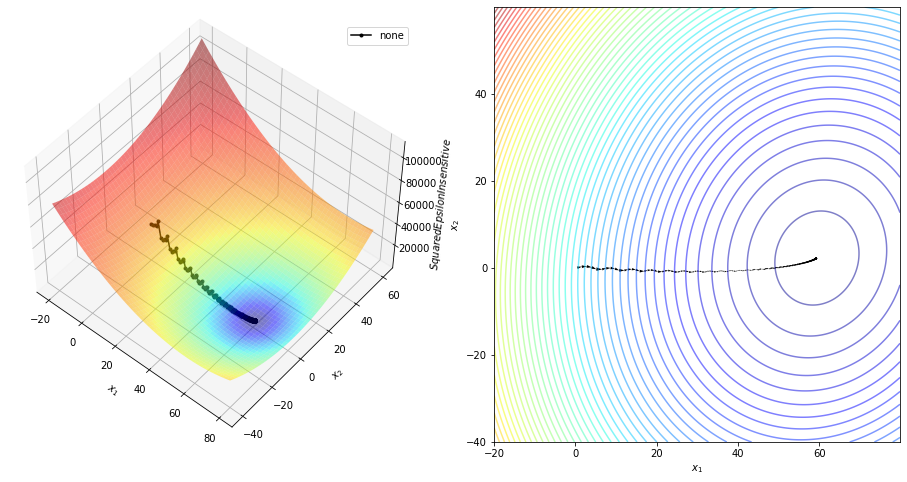

In [95]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              momentum_type='none', learning_rate=0.001, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_ins_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-20, x_max=80, y_min=-40, y_max=60)
squared_eps_ins_loss_opt = plot_trajectory_optimization(squared_eps_ins_loss, grid.best_estimator_.optimizer, 
                                                        color='k', label='none')

In [96]:
none_primal_svr_squared_eps_ins_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svr_squared_eps_ins_cv_results.insert(0, 'solver', 'sgd')
none_primal_svr_squared_eps_ins_cv_results.insert(2, 'momentum', 'none')
none_primal_svr_squared_eps_ins_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
none_primal_svr_squared_eps_ins_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver C   momentum epsilon                                                     
sgd    1   none     0.1      1.274976     825  0.977343  0.972962          66   
                    0.2      1.265650     814  0.977337  0.972946          65   
                    0.3      1.151264     803  0.977329  0.972927          65   
       10  none     0.1      0.154300      99  0.978098  0.973423          66   
                    0.2      0.151321     100  0.978098  0.973424          65   
                    0.3      0.151889     100  0.978097  0.973420          64   
       100 none     0.1      0.024512      15  0.977779  0.973078          65   
                    0.2      0.024470      15  0.977779  0.973078          65   
                    0.3      0.022335      15  0.977778  0.973084          64   

                             val_n_sv  
solver C   momentum epsilon            
sgd    1   none     0.1            33  
                    0.2            33  
                    0.3            33  
       10  none     0.1            33  
                    0.2            32  
                    0.3            32  
       100 none     0.1            33  
                    0.2            32  
                    0.3            32

Fitting 3 folds for each of 9 candidates, totalling 27 fits


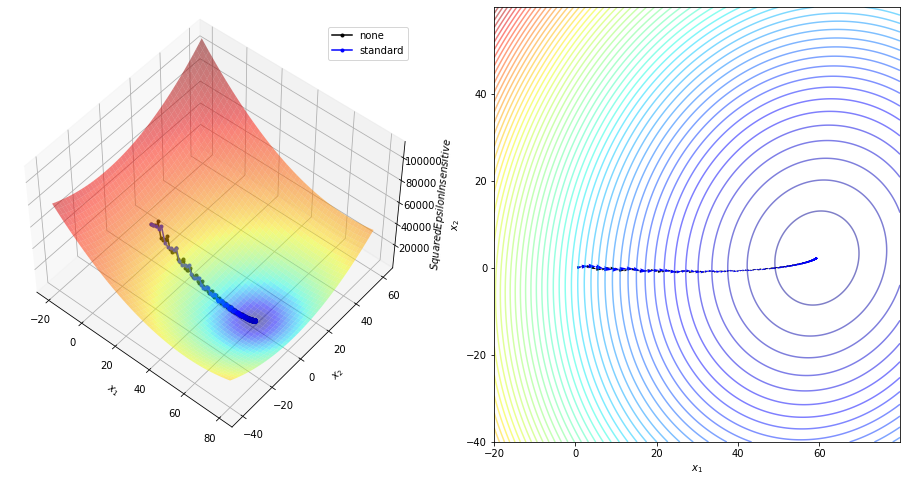

In [97]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              momentum_type='standard', momentum=0.4, learning_rate=0.001, batch_size=20, 
                              early_stopping=True, random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_ins_loss_opt = plot_trajectory_optimization(squared_eps_ins_loss_opt, grid.best_estimator_.optimizer, 
                                                        color='b', label='standard')
squared_eps_ins_loss_opt

In [98]:
standard_primal_svr_squared_eps_ins_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svr_squared_eps_ins_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svr_squared_eps_ins_cv_results.insert(2, 'momentum', 'standard')
standard_primal_svr_squared_eps_ins_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
standard_primal_svr_squared_eps_ins_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver C   momentum epsilon                                                     
sgd    1   standard 0.1      0.849939     534  0.977359  0.972998          66   
                    0.2      0.826579     525  0.977354  0.972985          65   
                    0.3      0.737108     516  0.977349  0.972969          65   
       10  standard 0.1      0.093561      61  0.978099  0.973502          66   
                    0.2      0.097428      62  0.978099  0.973503          65   
                    0.3      0.094527      62  0.978099  0.973505          65   
       100 standard 0.1      0.014060       8  0.977853  0.973014          66   
                    0.2      0.014139       8  0.977853  0.973017          64   
                    0.3      0.014335      10  0.977853  0.973014          64   

                             val_n_sv  
solver C   momentum epsilon            
sgd    1   standard 0.1            33  
                    0.2            33  
                    0.3            33  
       10  standard 0.1            33  
                    0.2            32  
                    0.3            32  
       100 standard 0.1            32  
                    0.2            32  
                    0.3            31

Fitting 3 folds for each of 9 candidates, totalling 27 fits


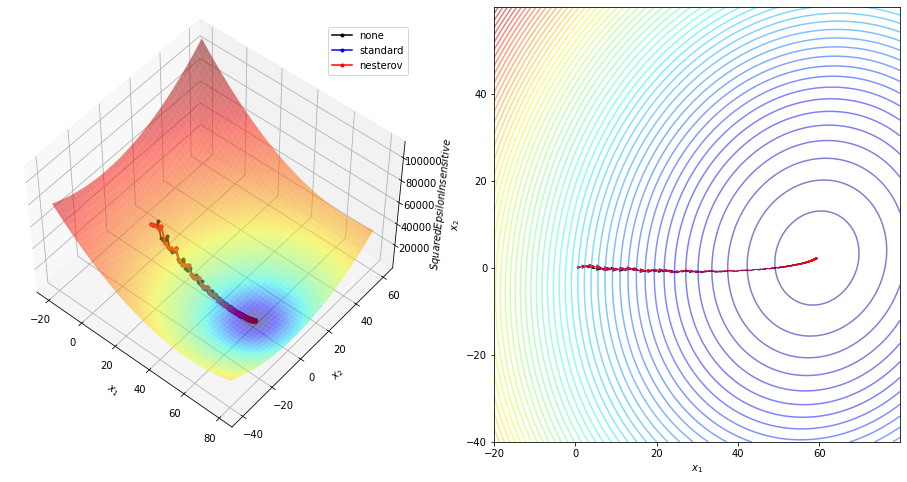

In [99]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              momentum_type='nesterov', momentum=0.4, learning_rate=0.001, batch_size=20, 
                              early_stopping=True, random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_ins_loss_opt = plot_trajectory_optimization(squared_eps_ins_loss_opt, grid.best_estimator_.optimizer, 
                                                        color='r', label='nesterov')
squared_eps_ins_loss_opt.savefig('./tex/img/svr_squared_eps_loss.png')
squared_eps_ins_loss_opt

In [100]:
nesterov_primal_svr_squared_eps_ins_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svr_squared_eps_ins_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svr_squared_eps_ins_cv_results.insert(2, 'momentum', 'nesterov')
nesterov_primal_svr_squared_eps_ins_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
nesterov_primal_svr_squared_eps_ins_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver C   momentum epsilon                                                     
sgd    1   nesterov 0.1      0.855992     534  0.977358  0.972997          66   
                    0.2      0.861291     526  0.977354  0.972985          65   
                    0.3      0.743692     515  0.977348  0.972967          65   
       10  nesterov 0.1      0.096757      62  0.978100  0.973491          66   
                    0.2      0.097347      62  0.978100  0.973493          65   
                    0.3      0.095362      63  0.978100  0.973495          65   
       100 nesterov 0.1      0.019476      10  0.977838  0.973043          66   
                    0.2      0.017619      10  0.977838  0.973042          64   
                    0.3      0.015698      10  0.977838  0.973045          64   

                             val_n_sv  
solver C   momentum epsilon            
sgd    1   nesterov 0.1            33  
                    0.2            33  
                    0.3            33  
       10  nesterov 0.1            33  
                    0.2            32  
                    0.3            32  
       100 nesterov 0.1            32  
                    0.2            32  
                    0.3            31

In [101]:
custom_primal_svr_squared_eps_cv_results = none_primal_svr_squared_eps_ins_cv_results.append(standard_primal_svr_squared_eps_ins_cv_results).append(nesterov_primal_svr_squared_eps_ins_cv_results)
custom_primal_svr_squared_eps_cv_results.sort_values(['C', 'momentum'], key=lambda x: x.astype(str).str.len(), inplace=True)
custom_primal_svr_squared_eps_cv_results

fit_time  n_iter  train_r2    val_r2  train_n_sv  \
solver C   momentum epsilon                                                     
sgd    1   none     0.1      1.274976     825  0.977343  0.972962          66   
                    0.2      1.265650     814  0.977337  0.972946          65   
                    0.3      1.151264     803  0.977329  0.972927          65   
           standard 0.1      0.849939     534  0.977359  0.972998          66   
                    0.2      0.826579     525  0.977354  0.972985          65   
                    0.3      0.737108     516  0.977349  0.972969          65   
           nesterov 0.1      0.855992     534  0.977358  0.972997          66   
                    0.2      0.861291     526  0.977354  0.972985          65   
                    0.3      0.743692     515  0.977348  0.972967          65   
       10  none     0.1      0.154300      99  0.978098  0.973423          66   
                    0.2      0.151321     100  0.978098  0.973424          65   
                    0.3      0.151889     100  0.978097  0.973420          64   
           standard 0.1      0.093561      61  0.978099  0.973502          66   
                    0.2      0.097428      62  0.978099  0.973503          65   
                    0.3      0.094527      62  0.978099  0.973505          65   
           nesterov 0.1      0.096757      62  0.978100  0.973491          66   
                    0.2      0.097347      62  0.978100  0.973493          65   
                    0.3      0.095362      63  0.978100  0.973495          65   
       100 none     0.1      0.024512      15  0.977779  0.973078          65   
                    0.2      0.024470      15  0.977779  0.973078          65   
                    0.3      0.022335      15  0.977778  0.973084          64   
           standard 0.1      0.014060       8  0.977853  0.973014          66   
                    0.2      0.014139       8  0.977853  0.973017          64   
                    0.3      0.014335      10  0.977853  0.973014          64   
           nesterov 0.1      0.019476      10  0.977838  0.973043          66   
                    0.2      0.017619      10  0.977838  0.973042          64   
                    0.3      0.015698      10  0.977838  0.973045          64   

                             val_n_sv  
solver C   momentum epsilon            
sgd    1   none     0.1            33  
                    0.2            33  
                    0.3            33  
           standard 0.1            33  
                    0.2            33  
                    0.3            33  
           nesterov 0.1            33  
                    0.2            33  
                    0.3            33  
       10  none     0.1            33  
                    0.2            32  
                    0.3            32  
           standard 0.1            33  
                    0.2            32  
                    0.3            32  
           nesterov 0.1            33  
                    0.2            32  
                    0.3            32  
       100 none     0.1            33  
                    0.2            32  
                    0.3            32  
           standard 0.1            32  
                    0.2            32  
                    0.3            31  
           nesterov 0.1            32  
                    0.2            32  
                    0.3            31

In [102]:
grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive', random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [103]:
liblinear_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_squared_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_squared_eps_cv_results.set_index(['solver', 'C', 'momentum', 'epsilon'], inplace=True)
liblinear_primal_svr_squared_eps_cv_results

fit_time  n_iter  train_r2    val_r2  \
solver    C   momentum epsilon                                         
liblinear 1   -        0.1      0.001004      84  0.978134  0.973997   
                       0.2      0.001132      84  0.978132  0.974006   
                       0.3      0.001113      83  0.978130  0.974011   
          10  -        0.1      0.003276     768  0.978183  0.973959   
                       0.2      0.003045     765  0.978183  0.973965   
                       0.3      0.003119     765  0.978183  0.973970   
          100 -        0.1      0.004366    1000  0.978025  0.973097   
                       0.2      0.004579    1000  0.978029  0.973107   
                       0.3      0.004397    1000  0.978033  0.973116   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
liblinear 1   -        0.1              67        32  
                       0.2              66        32  
                       0.3              66        32  
          10  -        0.1              66        33  
                       0.2              66        33  
                       0.3              66        32  
          100 -        0.1              66        33  
                       0.2              66        33  
                       0.3              65        32

In [104]:
primal_svr_squared_eps_cv_results = custom_primal_svr_squared_eps_cv_results.append(liblinear_primal_svr_squared_eps_cv_results)
primal_svr_squared_eps_cv_results.to_latex('./tex/experiments/primal_svr_squared_eps.tex', 
                                           caption='SVR Primal formulation results with Squared Epsilon-insensitive loss', 
                                           label='primal_svr_squared_eps_cv_results', position='H')
primal_svr_squared_eps_cv_results

fit_time  n_iter  train_r2    val_r2  \
solver    C   momentum epsilon                                         
sgd       1   none     0.1      1.274976     825  0.977343  0.972962   
                       0.2      1.265650     814  0.977337  0.972946   
                       0.3      1.151264     803  0.977329  0.972927   
              standard 0.1      0.849939     534  0.977359  0.972998   
                       0.2      0.826579     525  0.977354  0.972985   
                       0.3      0.737108     516  0.977349  0.972969   
              nesterov 0.1      0.855992     534  0.977358  0.972997   
                       0.2      0.861291     526  0.977354  0.972985   
                       0.3      0.743692     515  0.977348  0.972967   
          10  none     0.1      0.154300      99  0.978098  0.973423   
                       0.2      0.151321     100  0.978098  0.973424   
                       0.3      0.151889     100  0.978097  0.973420   
              standard 0.1      0.093561      61  0.978099  0.973502   
                       0.2      0.097428      62  0.978099  0.973503   
                       0.3      0.094527      62  0.978099  0.973505   
              nesterov 0.1      0.096757      62  0.978100  0.973491   
                       0.2      0.097347      62  0.978100  0.973493   
                       0.3      0.095362      63  0.978100  0.973495   
          100 none     0.1      0.024512      15  0.977779  0.973078   
                       0.2      0.024470      15  0.977779  0.973078   
                       0.3      0.022335      15  0.977778  0.973084   
              standard 0.1      0.014060       8  0.977853  0.973014   
                       0.2      0.014139       8  0.977853  0.973017   
                       0.3      0.014335      10  0.977853  0.973014   
              nesterov 0.1      0.019476      10  0.977838  0.973043   
                       0.2      0.017619      10  0.977838  0.973042   
                       0.3      0.015698      10  0.977838  0.973045   
liblinear 1   -        0.1      0.001004      84  0.978134  0.973997   
                       0.2      0.001132      84  0.978132  0.974006   
                       0.3      0.001113      83  0.978130  0.974011   
          10  -        0.1      0.003276     768  0.978183  0.973959   
                       0.2      0.003045     765  0.978183  0.973965   
                       0.3      0.003119     765  0.978183  0.973970   
          100 -        0.1      0.004366    1000  0.978025  0.973097   
                       0.2      0.004579    1000  0.978029  0.973107   
                       0.3      0.004397    1000  0.978033  0.973116   

                                train_n_sv  val_n_sv  
solver    C   momentum epsilon                        
sgd       1   none     0.1              66        33  
                       0.2              65        33  
                       0.3              65        33  
              standard 0.1              66        33  
                       0.2              65        33  
                       0.3              65        33  
              nesterov 0.1              66        33  
                       0.2              65        33  
                       0.3              65        33  
          10  none     0.1              66        33  
                       0.2              65        32  
                       0.3              64        32  
              standard 0.1              66        33  
                       0.2              65        32  
                       0.3              65        32  
              nesterov 0.1              66        33  
                       0.2              65        32  
                       0.3              65        32  
          100 none     0.1              65        33  
                       0.2              65        32  
                       0.3              64        32  
              standard 0.1    